In [31]:
%reset -f
import time
t_start = time.time()

In [32]:
!pwd

/root/work/QE-mls/5th_trial/qe-analysis


In [33]:
import sys
import os

# Verify the path
HOME_PATH = os.path.abspath('../..')
sys.path.insert(0, HOME_PATH + "/qe")

import my_cmaps

import numpy as np
import pandas as pd
import uproot
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [34]:
# designates the data path
DSID = 345324
# DSID = 504669
TREES = str(DSID) + ";1"
if DSID == 345324:
    TYPE = "powheg"
elif DSID == 504669:
    TYPE = "madgraph"
PATH = f"/root/data/ggm_truth_analysis/CAF_nTuple/{TYPE}_dump/"

# some constant
GEV = 1e-3
WORKERS = 64

In [35]:
!ls -lh $PATH

total 20K
drwxr-xr-x 2 1005 1006 4.0K Aug 18 13:28 CutLeadLeptonPt_Truth
drwxr-xr-x 2 1005 1006 4.0K Aug 18 13:29 CutOSLeptons_Truth
drwxr-xr-x 2 1005 1006 4.0K Aug 18 13:30 CutSubLeadLeptonPt_Truth
drwxr-xr-x 2 1005 1006 4.0K Aug 18 13:31 CutTruthChannels
drwxr-xr-x 2 1005 1006 4.0K Aug 18 13:32 CutTruthTopo


In [36]:
def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))


def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)

In [37]:
def load_data(path=PATH, cut_stage="CutTruthTopo"):
    file = uproot.open(path + cut_stage + f"/{DSID}_analyze.root")
    branches = file[TREES].keys()
    data = {
        branch.split(".")[-1]: file[TREES][branch].array(library="pd")
        for branch in branches
    }
    print(branches)
    return data

In [38]:
data_truth = load_data(cut_stage="CutOSLeptons_Truth")

['TruthQEHE', 'TruthQEHPx', 'TruthQEHPy', 'TruthQEHPz', 'TruthQEHM', 'TruthQEHPt', 'TruthQEHEta', 'TruthQEHPhi', 'TruthQEWpE', 'TruthQEWpPx', 'TruthQEWpPy', 'TruthQEWpPz', 'TruthQEWpM', 'TruthQEWpPt', 'TruthQEWpEta', 'TruthQEWpPhi', 'TruthQEWnE', 'TruthQEWnPx', 'TruthQEWnPy', 'TruthQEWnPz', 'TruthQEWnM', 'TruthQEWnPt', 'TruthQEWnEta', 'TruthQEWnPhi', 'TruthQELeppE', 'TruthQELeppPx', 'TruthQELeppPy', 'TruthQELeppPz', 'TruthQELeppM', 'TruthQELeppPt', 'TruthQELeppEta', 'TruthQELeppPhi', 'TruthQELepnE', 'TruthQELepnPx', 'TruthQELepnPy', 'TruthQELepnPz', 'TruthQELepnM', 'TruthQELepnPt', 'TruthQELepnEta', 'TruthQELepnPhi', 'TruthQENupE', 'TruthQENupPx', 'TruthQENupPy', 'TruthQENupPz', 'TruthQENupM', 'TruthQENupPt', 'TruthQENupEta', 'TruthQENupPhi', 'TruthQENunE', 'TruthQENunPx', 'TruthQENunPy', 'TruthQENunPz', 'TruthQENunM', 'TruthQENunPt', 'TruthQENunEta', 'TruthQENunPhi', 'TruthCandLep0E', 'TruthCandLep0Px', 'TruthCandLep0Py', 'TruthCandLep0Pz', 'TruthCandLep0M', 'TruthCandLep0Pt', 'TruthC

In [39]:
# truth stage leptons
# loading data

truth_lead_lep = (
    GEV
    * np.array(
        [
            data_truth[key]
            for key in [
                "TruthCandLep0Px",
                "TruthCandLep0Py",
                "TruthCandLep0Pz",
                "TruthCandLep0E",
            ]
        ]
    ).T
)
truth_sublead_lep = (
    GEV
    * np.array(
        [
            data_truth[key]
            for key in [
                "TruthCandLep1Px",
                "TruthCandLep1Py",
                "TruthCandLep1Pz",
                "TruthCandLep1E",
            ]
        ]
    ).T
)

# truth stage Ws
truth_w_pos = (
    GEV
    * np.array(
        [
            data_truth[key]
            for key in ["TruthQEWpPx", "TruthQEWpPy", "TruthQEWpPz", "TruthQEWpE"]
        ]
    ).T
)
truth_w_neg = (
    GEV
    * np.array(
        [
            data_truth[key]
            for key in ["TruthQEWnPx", "TruthQEWnPy", "TruthQEWnPz", "TruthQEWnE"]
        ]
    ).T
)

In [40]:
truth_w_pos_pt = pt(truth_w_pos[:, 0], truth_w_pos[:, 1])
truth_w_neg_pt = pt(truth_w_neg[:, 0], truth_w_neg[:, 1])
lead_mask = np.where(truth_w_pos_pt > truth_w_neg_pt, True, False)
truth_w_lead = np.where(lead_mask[:, np.newaxis], truth_w_pos, truth_w_neg)
truth_w_sublead = np.where(lead_mask[:, np.newaxis], truth_w_neg, truth_w_pos)

In [41]:
# main algorithm


def cglmp(z_xp, z_xn, z_yp, z_yn):
    """
    This is a function to calculate Bij (CGLMP values).
    :param z_xp: Angle (xi) between positive lepton and x-axis.
    :param z_xn: Angle (xi) between negative lepton and x-axis.
    :param z_yp: Angle (xi) between positive lepton and y-axis.
    :param z_xn: Angle (xi) between negative lepton and y-axis.
    """
    # count expectation value, use (27) in Alan's paper
    tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
    tr_b = (
        25 * (np.square(z_xp) - np.square(z_yp)) * (np.square(z_xn) - np.square(z_yn))
    )
    tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
    tr = tr_a + tr_b + tr_c

    return tr


def main_alg(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 5.1 Calculate GGM
    # GGM
    lp_pt = np.sqrt(
        np.square(WpLp_k.X()) + np.square(WpLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    ln_pt = np.sqrt(
        np.square(WnLp_k.X()) + np.square(WnLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    lp_phi = np.arctan2(WpLp_k.Y(), WpLp_k.X())  # phi = arctan(Py/Px)
    ln_phi = np.arctan2(WnLp_k.Y(), WnLp_k.X())  # phi = arctan(Py/Px)
    lp_theta = np.arctan(np.divide(lp_pt, WpLp_k.Z()))  # theta = arctan(PT/Pz)
    ln_theta = np.arctan(np.divide(ln_pt, WnLp_k.Z()))  # theta = arctan(PT/Pz)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
        np.array([lp_pt, lp_phi, lp_theta]),
        np.array([ln_pt, ln_phi, ln_theta]),
    )

In [42]:
# declare a generator for the resuts


def result_generator(particles):
    bij = np.zeros((particles.shape[0], 3))
    xi_lead = np.zeros((particles.shape[0], 3))
    xi_sublead = np.zeros((particles.shape[0], 3))
    ggm_lead = np.zeros((particles.shape[0], 3))
    ggm_sublead = np.zeros((particles.shape[0], 3))
    result = np.array((particles.shape[0], 3, 5))
    with multiprocessing.Pool(WORKERS) as pool:
        result = np.array(list(pool.map(main_alg, particles)))
    bij = result[:, 0]
    xi_lead = result[:, 1]
    xi_sublead = result[:, 2]
    ggm_lead = result[:, 3]
    ggm_sublead = result[:, 4]
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_lead[~mask, :],
        xi_sublead[~mask, :],
        ggm_lead[~mask, :],
        ggm_sublead[~mask, :],
        mask,
    )

In [43]:
# calculate results

# truth stage
truth_particles = np.concatenate(
    [truth_w_lead, truth_lead_lep, truth_w_sublead, truth_sublead_lep], axis=1
)
truth_bij, truth_xi_pos, truth_xi_neg, truth_ggm_pos, truth_ggm_neg, truth_mask = result_generator(
    truth_particles
)

In [44]:
# 8 Wigner P-symbols angular functions


def P1(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.cos(phi)


def P2(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.sin(phi)


def P3(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 0.25 * (c * 4 * np.cos(theta) + 15 * np.cos(2 * theta) + 5)


def P4(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.cos(2 * phi)


def P5(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.sin(2 * phi)


def P6(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.cos(phi)


def P7(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.sin(phi)


def P8(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(1 / 48) * (c * 12 * np.cos(theta) - 15 * np.cos(2 * theta) - 5)

In [45]:
def compute_Wigner(Phi_func: callable, angles: tuple, sign: str) -> np.float64:
    """
    Compute Wigner function for given angles and sign.
    """
    theta_0toPi, phi_0to2Pi = angles
    return Phi_func(theta_0toPi, phi_0to2Pi, sign)


def C_matrix(lp_theta, lp_phi, ln_theta, ln_phi):
    # Adjust angles to the paper requiring
    lp_theta_0toPi = np.where(lp_theta < 0, np.pi + lp_theta, lp_theta)
    ln_theta_0toPi = np.where(ln_theta < 0, np.pi + ln_theta, ln_theta)
    lp_phi_0to2Pi = np.where(lp_phi < 0, 2 * np.pi + lp_phi, lp_phi)
    ln_phi_0to2Pi = np.where(ln_phi < 0, 2 * np.pi + ln_phi, ln_phi)

    PSymb = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
    Phi_functions = [P1, P2, P3, P4, P5, P6, P7, P8]

    # Compute Wigner functions
    WignerPp_results = [
        compute_Wigner(Phi, (lp_theta_0toPi, lp_phi_0to2Pi), "pos")
        for Phi in Phi_functions
    ]
    WignerPn_results = [
        compute_Wigner(Phi, (ln_theta_0toPi, ln_phi_0to2Pi), "neg")
        for Phi in Phi_functions
    ]

    # Construct DataFrames from results
    WignerPp = pd.DataFrame(
        {PSymb[i] + "+": result for i, result in enumerate(WignerPp_results)}
    )
    WignerPn = pd.DataFrame(
        {PSymb[i] + "-": result for i, result in enumerate(WignerPn_results)}
    )

    # Compute C matrix using vectorized operations
    C = np.zeros((9, 9))
    C[0, 1:] = WignerPp.mean() * 0.5
    C[1:, 0] = WignerPn.mean() * 0.5
    for i in range(8):
        for j in range(8):
            C[i + 1, j + 1] = np.mean(WignerPn.iloc[:, i] * WignerPp.iloc[:, j]) * 0.25

    return C, WignerPp, WignerPn

In [46]:
# retrieve elements from P-symbol Phi functions

# truth stage
truth_phi_pos, truth_phi_neg = truth_ggm_pos[:, 1], truth_ggm_neg[:, 1]
truth_theta_pos, truth_theta_neg = truth_ggm_pos[:, 2], truth_ggm_neg[:, 2]

In [47]:
# calculate C matrix and Wigner P-symbol functions

truth_C, _, _ = C_matrix(truth_theta_pos, truth_phi_pos, truth_theta_neg, truth_phi_neg)

In [48]:
def ggm_plot(C, title="RAW"):
    fig, ax = plt.subplots(figsize=(7, 7), dpi=120)
    xx, yy = np.meshgrid(np.arange(9), np.arange(9))
    im = ax.pcolormesh(
        xx,
        yy,
        C,
        cmap=my_cmaps.hotcold(neutral=1.0),
        vmin=-0.25,
        vmax=0.25,
        shading="auto",
    )
    ax.set_aspect(1)
    # Remove the tick lines
    ax.tick_params(axis="both", which="minor", tick1On=False, tick2On=False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation="vertical")
    ticks = np.arange(-0.25, 0.26, 0.05)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_verticalalignment("center")
    for label in ax.get_yticklabels(minor=True):
        label.set_horizontalalignment("center")
    ax.set_xticks(np.arange(9))
    ax.set_xlabel(r"$W^{lead}$ GM index", fontsize=12)
    ax.set_ylabel(r"$W^{sublead}$ GM index", fontsize=12)
    ax.set_title(f"{title} " + r"$pp\to H \to WW^* \to \ell \nu \ell \nu$", fontsize=16)
    plt.show()
    plt.close()

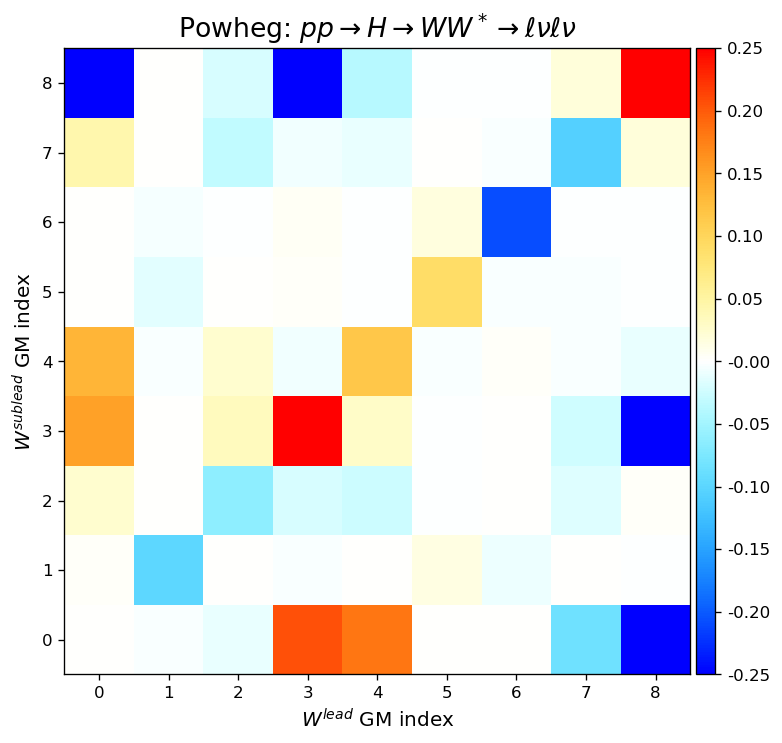

In [49]:
# raw
ggm_plot(truth_C, "Powheg:")

In [50]:
t_end = time.time()
print(f"Total spending time: {t_end-t_start: .2f} (s)")

Total spending time:  14.55 (s)
